#### Импортирование библиотек

In [30]:
import pandas as pd
import torch
from pathlib import Path
from torch.utils.data.dataset import Dataset
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
from PIL import Image
from PIL import Image, ImageDraw, ImageFont
import glob
import datetime
from math import sqrt

from time import time

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

import IPython.display as ipd

from tqdm.notebook import tqdm
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

import sklearn
clear_output()


Обучение будет происходить на видеокарте Tesla T4 на платформе Google Colab.

In [2]:
!nvidia-smi

Thu Dec 22 07:10:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    34W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Загрузка данных

В качестве основного текстового датасета я буду использовать новости источника lenta.ru. Данный объект содержит около 900 тысяч различных новостных статей, более 30 слов каждая. Используя некоторый стандартный набор букв, цифр и знаков, уберем те слова из предложений, которые не содержат символы из алфавита. При этом, использование даже 10% всего датасета позволит получить около 100 тысяч "уникальных слов".


Полученный набор слов я буду накладывать на фон картинок из датасета DIV2K, представляющий из себя 800 изображений выского разрешения, что позволяет использовать RandomCrop вместо Resize (по мере необходимости, если изначальное изображение будет меньше необходимого), что сильно ускоряет процесс семплирования элемента. 

In [2]:
DIR= Path('/content/lenta-ru-news.csv')
DIR2= Path('/content/tiny-imagenet-200')
alphabet= '^ ,-.:"АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя0123456789'
#alphabet= '^ ,-.:"абвгдеёжзийклмнопрстуфхцчшщъыьэюя0123456789'
alphabet_dct= {}
for idx, item in enumerate(alphabet):
  alphabet_dct[item]= idx

if not DIR.exists() or not DIR2.exists():
  drive.mount('/content/gdrive/')
  !unzip -q /content/gdrive/MyDrive/data/News/archive.zip
  #!unzip -q /content/gdrive/MyDrive/data/TinyImageNet/archive.zip
  !unzip -q /content/gdrive/MyDrive/data/DIV2K/archive.zip

text_data=  pd.read_csv("/content/lenta-ru-news.csv")['text'][:10**4]
correct_sentence= set()
for idx, sentence in tqdm(enumerate(text_data)):  # Убираем англоязычные слова. Также в присутствуют пустые предложения, которые обрабатываются try-except
  try:
    for word in sentence.strip().split():
      if set(word) & set(alphabet) == set(word)  and 4<=len(word)<10 and word not in correct_sentence:
        correct_sentence.add(word)
  except:
    pass

text_data= np.array([*correct_sentence])
print(len(text_data), text_data[:5])

Mounted at /content/gdrive/


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0it [00:00, ?it/s]

90266 ['"Мираж' 'подданном' 'плану' 'подписка' 'сам,']


In [68]:
class MyData(Dataset):
  def __init__(self, text_data, image_size= (128, 32), word_length= 10, letter_size=(14,18), L_mode= True, random_image= False):
    self.text_data= text_data
    self.Fonts= glob.glob('/content/gdrive/MyDrive/data/Fonts/*.ttf')
    #self.DataImages= list(Path('/content/gdrive/MyDrive/data/DIV2K_train_LR_bicubic_X4/DIV2K_train_LR_bicubic/X4').rglob('*.png'))
    self.DataImages= list(Path('/content/DIV2K_train_HR/DIV2K_train_HR/').rglob('*.png'))
    self.image_size= image_size
    self.word_length= word_length
    self.random_image= random_image
    self.letter_size= letter_size
    self.L_mode= L_mode
    
    self.crop= tt.RandomCrop(image_size[::-1])

    self.second_transform= tt.Compose([
        tt.RandomRotation(degrees= 5, fill= 255),
        tt.ToTensor(),
        tt.ConvertImageDtype(torch.float), #-> [0,1]
    ])

  def text_to_target(self, text_data):
    text_data= text_data+'^'*(self.word_length-len(text_data))
    return torch.tensor([alphabet_dct[letter] for letter in text_data])
  
  def target_to_text(self, target):
    return ([alphabet[letter] for letter in target])

  def create_image(self, text_data):
    size= np.random.randint(*self.letter_size)
    if self.random_image:
      image= self.crop(Image.open(np.random.choice(self.DataImages)))
      if self.L_mode: image= image.convert('L')
    else:
      image = Image.new(mode="L", size=self.image_size, color="white")
    font = ImageFont.truetype(np.random.choice(self.Fonts), size= size)
    text_data_size = np.array(font.getsize(text_data))
    x_start, y_start= np.random.uniform(low=self.image_size[0]*0.05, high= self.image_size[0]/1.2-text_data_size[0]), np.random.uniform(low=self.image_size[1]*0.05, high= self.image_size[1]/1.2-text_data_size[1])
    x_end, y_end= x_start+text_data_size[0], y_start+text_data_size[1]
    delta_x, delta_y= text_data_size[0]*0.05, text_data_size[1]*0.3
    #coordinates= torch.tensor([x_start-1.3*delta_x-3, y_start-1.3*delta_y-1, x_end+1.3*delta_x+3, y_end+1.3*delta_y+1]) # увеличиваем размеры, чтобы все слово попадало на картинку при повороде, желательно нужно прибавлять и убавлят по5
    coordinates= torch.tensor([(x_start-delta_x-3)/self.image_size[0], (y_start-delta_y-2)/self.image_size[1], (x_end+delta_x+3)/self.image_size[0], (y_end+delta_y+2)/self.image_size[1]])

    draw = ImageDraw.Draw(image)
    draw.text((x_start, y_start), text_data, font=font, fill= 'black')

    image= self.second_transform(image)

    return image, coordinates

  def __len__(self):
    return len(self.text_data)
  
  def __getitem__(self, index):
    sentence= self.text_data[index] # семплируем слово
    target= self.text_to_target(sentence) # имбидим его
    image, coordinates= self.create_image(sentence)

    return image, target, len(sentence), coordinates

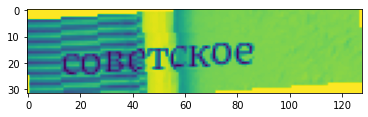

In [ ]:
data= MyData(text_data, random_image= True)
image, target, l, coordinates= data.__getitem__(1)
plt.imshow(image[0])
plt.show()

#### LSTM text recognition model

Научим модель понимать, что за слово изображено на небольшой части картинки. Для этого будем использовать сверточную архетектуру вместе LSTM и полносвязаннымы слоеми классификации в конце. Классификация происходит на число классов, равное длине словаря букв "alphabet".  

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.block= nn.Sequential(
        nn.Conv2d(in_channels= 1, out_channels= 16, kernel_size= 3, stride= 1, padding= 1),
        nn.ReLU(),

        nn.Conv2d(in_channels= 16, out_channels= 32, kernel_size= 3, stride= 1, padding= 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2, stride= 2),  # 16, 64

        nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size= 3, stride= 1, padding= 1),
        nn.BatchNorm2d(num_features= 64),
        nn.ReLU(),

        nn.Conv2d(in_channels= 64, out_channels= 128, kernel_size= 3, stride= 1, padding= 1),
        nn.BatchNorm2d(num_features= 128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2, stride= 2), # 8, 32

        nn.Conv2d(in_channels= 128, out_channels= 256, kernel_size= 3, stride= 1, padding= 1),
        nn.BatchNorm2d(num_features= 256),
        nn.ReLU(),

        nn.Conv2d(in_channels= 256, out_channels= 512, kernel_size= 3, stride= 1, padding= 1),
        nn.BatchNorm2d(num_features= 512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= (2,1), stride= (2,1)), # 4, 32

        nn.Conv2d(in_channels= 512, out_channels= 512, kernel_size= 2, stride=1) # 3, 31
    )
  
  def forward(self, x): # [B, 1, 32, 128]
    return self.block(x)

In [ ]:
class TextRecognitionModel(nn.Module):
  def __init__(self, num_classes, hidden_size= 256, num_layers= 2): #
    super().__init__()

    self.conv_block= ConvBlock() 
    self.adaptive_flatt= nn.Sequential(
        nn.AdaptiveAvgPool2d(output_size= (1, None)),
        nn.Flatten(start_dim=2, end_dim=- 1)
    )

    self.recurent_layer= nn.LSTM(input_size= 512, hidden_size= hidden_size, num_layers= num_layers, bidirectional= True, batch_first= True, dropout= 0.2)
    self.classify_block= nn.Sequential(
        nn.Linear(in_features= 2*hidden_size , out_features= hidden_size),
        nn.ReLU(), 
        nn.Dropout(p= 0.5),

        nn.Linear(in_features= hidden_size , out_features= num_classes),
        nn.LogSoftmax(dim=2)
    )
  

  def forward(self, x): # x -> [B, 1, 32, 128]
    x= self.conv_block(x) # x -> [B, 512, 3, 31]
    x= self.adaptive_flatt(x) # x -> [B, 512, 31]
    x= torch.permute(x, (0, 2, 1)) #  x -> [B, 31, 512]
    x, (h0, c0)= self.recurent_layer(x) # x -> [B, 31, 2*hidden_size]
    x= torch.permute(x, (1, 0, 2)) # [31, B, 2*hidden_size]
    x= self.classify_block(x) # x -> [31, B, num_classes]
    return x


In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
lr= 1E-4
max_epoch= 30
savepoint= 5
checkpoint= 2
dtime= datetime.datetime.today()

model= TextRecognitionModel(num_classes= len(alphabet), hidden_size= 256, num_layers= 2).to(device)
optimizer= torch.optim.Adam(model.parameters(), lr= lr)
criterion= nn.CTCLoss()
scheduler= torch.optim.lr_scheduler.MultiStepLR(optimizer, [25], gamma= 0.1)

In [ ]:
batch_size= 512
random_state= 42

x_train, x_test= train_test_split(text_data, test_size= 0.2, shuffle= True, random_state= random_state)
x_train_data, x_test_data= MyData(x_train), MyData(x_test)
train_data_loader= DataLoader(MyData(x_train, random_image= True), batch_size= batch_size, shuffle= True, drop_last= True)
test_data_loader= DataLoader(MyData(x_test, random_image= True), batch_size= batch_size, shuffle= True, drop_last= True)

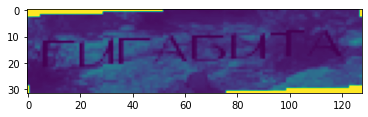

tensor([14, 26, 14,  8, 10, 26, 46,  8,  0,  0]) tensor(8)
^ ,-.:"АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя0123456789


In [ ]:
with torch.no_grad():
  for image_batch, target_batch, target_length, _ in train_data_loader:
    plt.imshow(image_batch[0][0])
    plt.show()
    print(target_batch[0], target_length[0])
    print(alphabet)
    break

#### LSTM обучение

In [ ]:
def train(model, criterion, optimizer, train_data_loader, test_data_loader, scheduler, savepoint= 5, checkpoint= 2):
  loss_train_history, loss_test_history= [], []

  for epoch in tqdm(range(1, max_epoch+1)):
    batch_train_counter, batch_test_counter= 0, 0
    loss_train_counter, loss_test_counter= 0, 0

    model.train()
    for image_batch, target_batch, target_length, _ in tqdm(train_data_loader):
      image_batch= image_batch.to(device)
      target_batch= target_batch.to(device)
      target_length= target_length.to(device)

      optimizer.zero_grad()
      predict= model(image_batch)
      # CTCLoss wants [31, B, len(alphabet)] size
      #input_length= torch.full(size=(batch_size,), fill_value= predict.shape[0], dtype=torch.long).to(device)
      input_length = torch.zeros(batch_size).type(torch.IntTensor).to(device)
      input_length.fill_(31)
      loss= criterion(predict, target_batch, input_length, target_length).to(device) # !!!!!!!!!!!!
      loss.backward()
      optimizer.step()

      batch_train_counter+= 1
      loss_train_counter+= loss.to('cpu')
    
    loss_train_history.append(loss_train_counter/batch_train_counter)
    scheduler.step()

    ##############################################################
    model.eval()
    with torch.no_grad():
      if epoch % checkpoint==0:
        for image_batch, target_batch, target_length, _ in tqdm(test_data_loader):
          image_batch= image_batch.to(device)
          target_batch= target_batch.to(device)
          target_length= target_length.to(device)

          predict= model(image_batch)
          # CTCLoss wants [31, B, len(alphabet)] size
          #input_length= torch.full(size=(batch_size,), fill_value= predict.shape[0], dtype=torch.long).to(device)
          input_length = torch.zeros(batch_size).type(torch.IntTensor).to(device)
          input_length.fill_(31)
          loss= criterion(predict, target_batch, input_length, target_length).to(device)

          batch_test_counter+= 1
          loss_test_counter+= loss.to('cpu')

        clear_output(wait=False)
        loss_test_history.append(loss_test_counter/batch_test_counter)

        plt.imshow(image_batch[0][0].to('cpu'))
        fig, ax= plt.subplots(nrows= 1, ncols= 2, figsize= (16,10))
        ax[0].plot(np.arange(1, epoch+1, 1), loss_train_history)
        ax[1].plot([i*checkpoint for i in range(1, len(loss_test_history)+1)], loss_test_history)
        ax[0].set_title('train')
        ax[1].set_title('test')
        plt.show()
        print(torch.argmax(predict[:,0,:].to('cpu'), dim= 1))
        print(target_batch[0].to('cpu'))
      
      if epoch % savepoint == 0: torch.save(model.state_dict(), '/content/TRM{}_{}_{}.pt'.format(epoch,dtime.hour, dtime.minute))

Обучение происходит при параметрах: batch_size= 512, lr= 3E-4, 11 заранее скаченных шрифтах с размером букв 14-18 пиксилей.

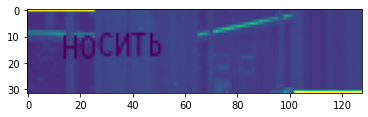

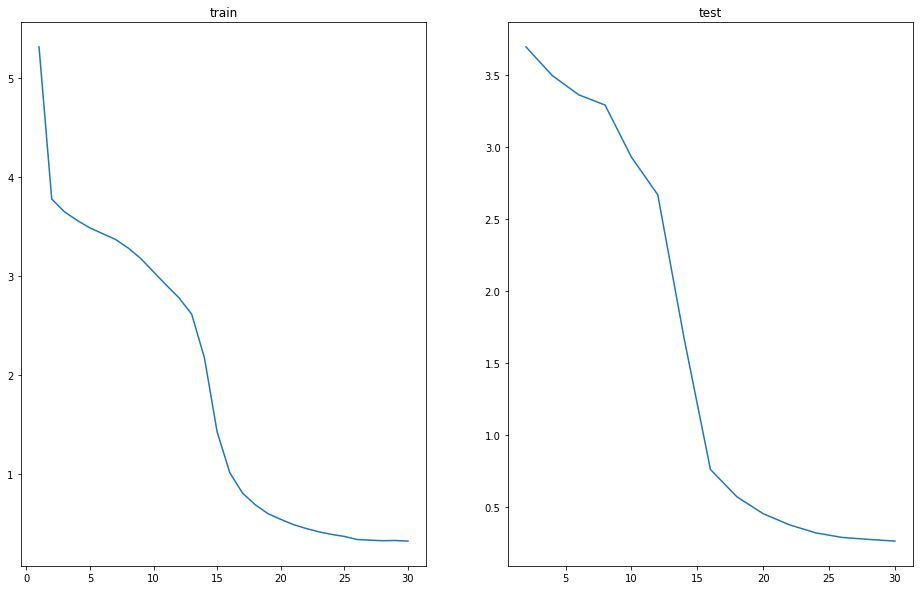

tensor([36,  0,  0, 38,  0, 44, 26,  0, 46,  0, 66,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
tensor([36, 38, 44, 26, 46, 66,  0,  0,  0,  0])


In [ ]:
train(model, criterion, optimizer, train_data_loader, test_data_loader, scheduler, savepoint= 5, checkpoint= 2)

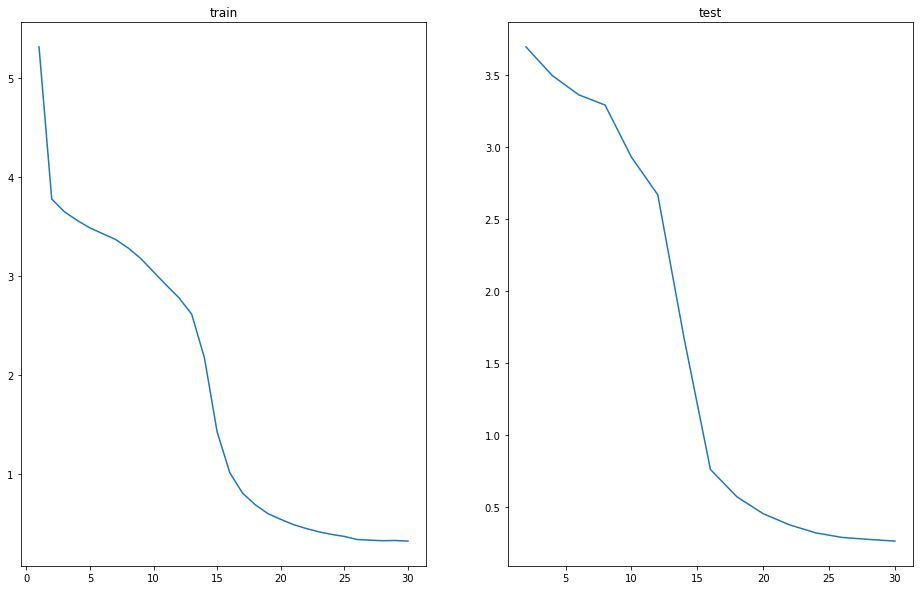

predict= tensor([36,  0,  0, 38,  0, 44, 26,  0, 46,  0, 66,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])


target= tensor([36, 38, 44, 26, 46, 66,  0,  0,  0,  0])

Лосс не трейне и тест части перестал значительно изменятся, по-этому, я не стал продолжать обучение дальше.

#### SSD text detection model

Для того, чтобы выделять из изображения слова буквы нам необходимо сначала это слово найти. Для этого будет использован
[SSD: Single Shot MultiBox Detector](https://https://arxiv.org/pdf/1512.02325.pdf). Изначально данная архетектура плохо работает при детектировании протяженных объектов, но это можно исправить, задав другое соотношение сторон при генерации априорных боксов. Также, я добавил Adaptive averege pooling в структуру backbone, что позволит корректно работать с любыми изображениями размера больше 300*300.

[Original SSD guide](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection)


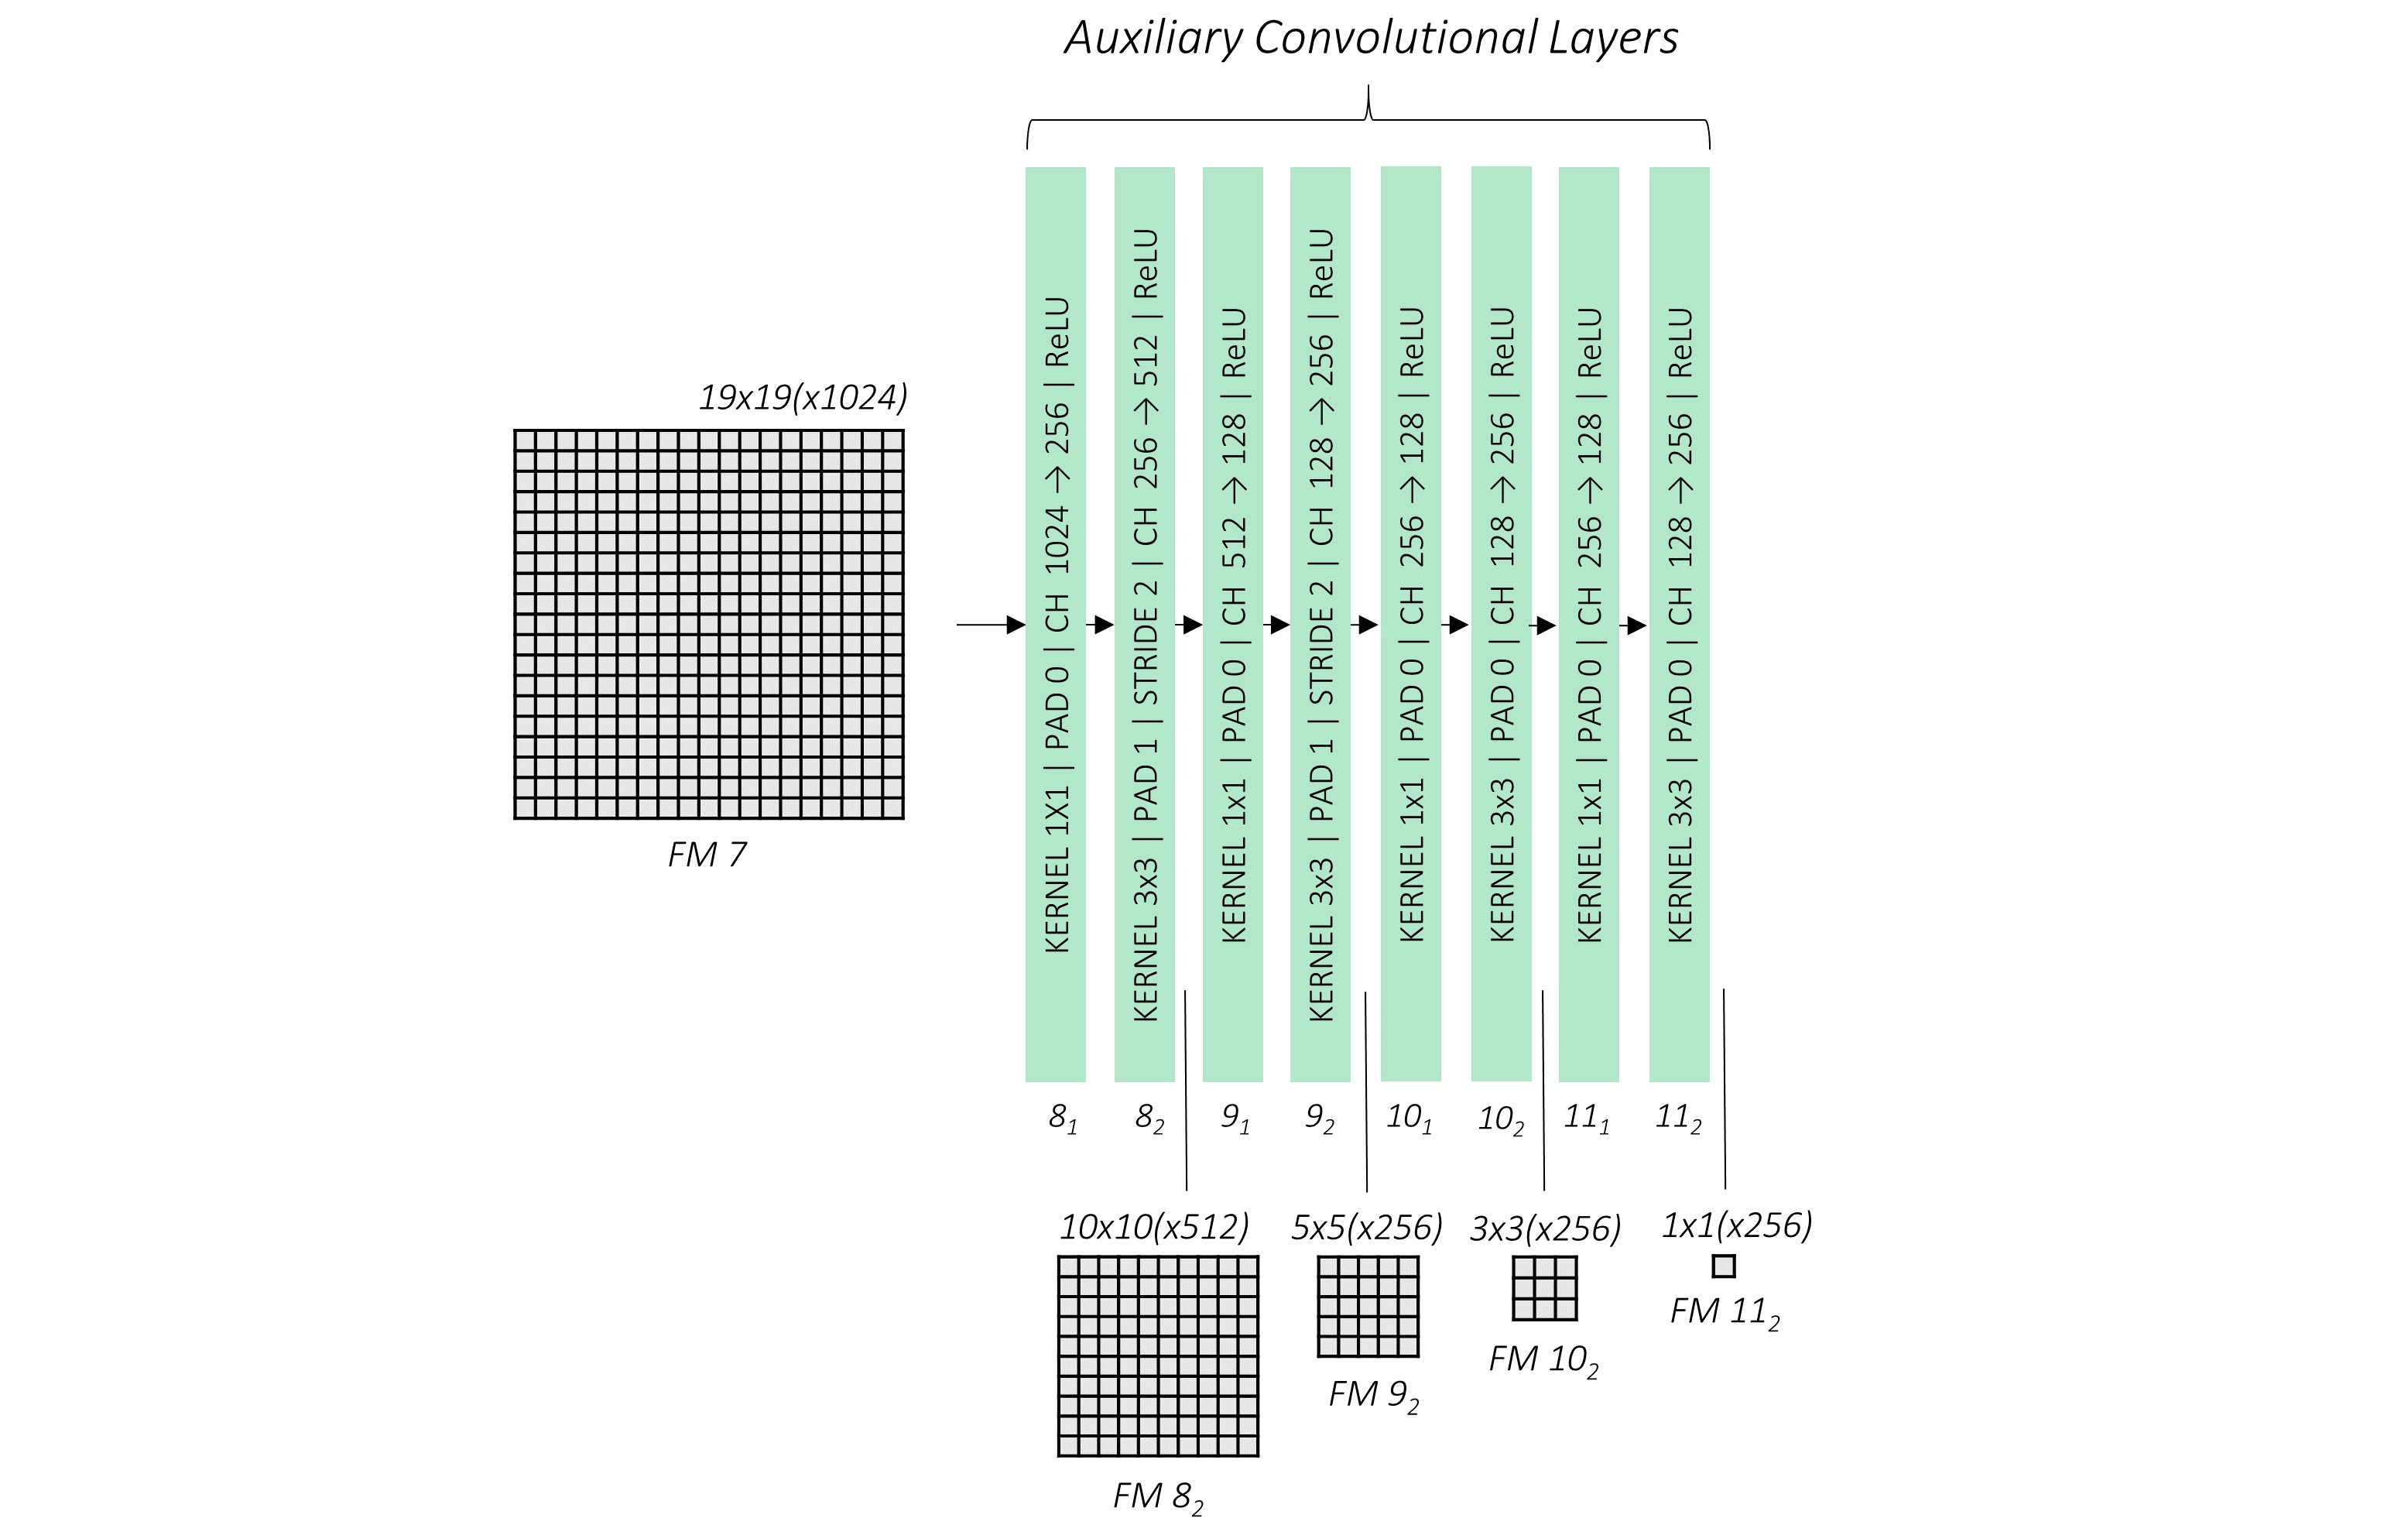

In [4]:
from torch.nn.modules.pooling import AdaptiveAvgPool2d
class AuxiliaryConvolutionLayers(nn.Module):
  def __init__(self, in_channels=1024):
    super().__init__()
    self.conv_block8= nn.Sequential(
        nn.Conv2d(in_channels, 256, kernel_size= 1, stride= 1),
        nn.ReLU(),
        nn.Conv2d(256, 512, kernel_size= 3, stride= 2, padding= 1),
        nn.ReLU()
    )

    self.conv_block9= nn.Sequential(
        nn.Conv2d(512, 128, kernel_size= 1, stride= 1),
        nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size= 3, stride= 2, padding= 1),
        nn.ReLU()
    )

    self.conv_block10= nn.Sequential(
        nn.Conv2d(256, 128, kernel_size= 1, stride= 1),
        nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size= 3, stride= 1, padding= 0),
        nn.ReLU()
    )

    self.conv_block11= nn.Sequential(
        nn.Conv2d(256, 128, kernel_size= 1, stride= 1),
        nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size= 3, stride= 2, padding= 0),
        nn.ReLU()
    )

  def forward(self, x):
      x= self.conv_block8(x)
      output8= x
      x= self.conv_block9(x)
      output9= x
      x= self.conv_block10(x)
      output10= x
      x= self.conv_block11(x)
      output11= x
      return output8, output9, output10, output11

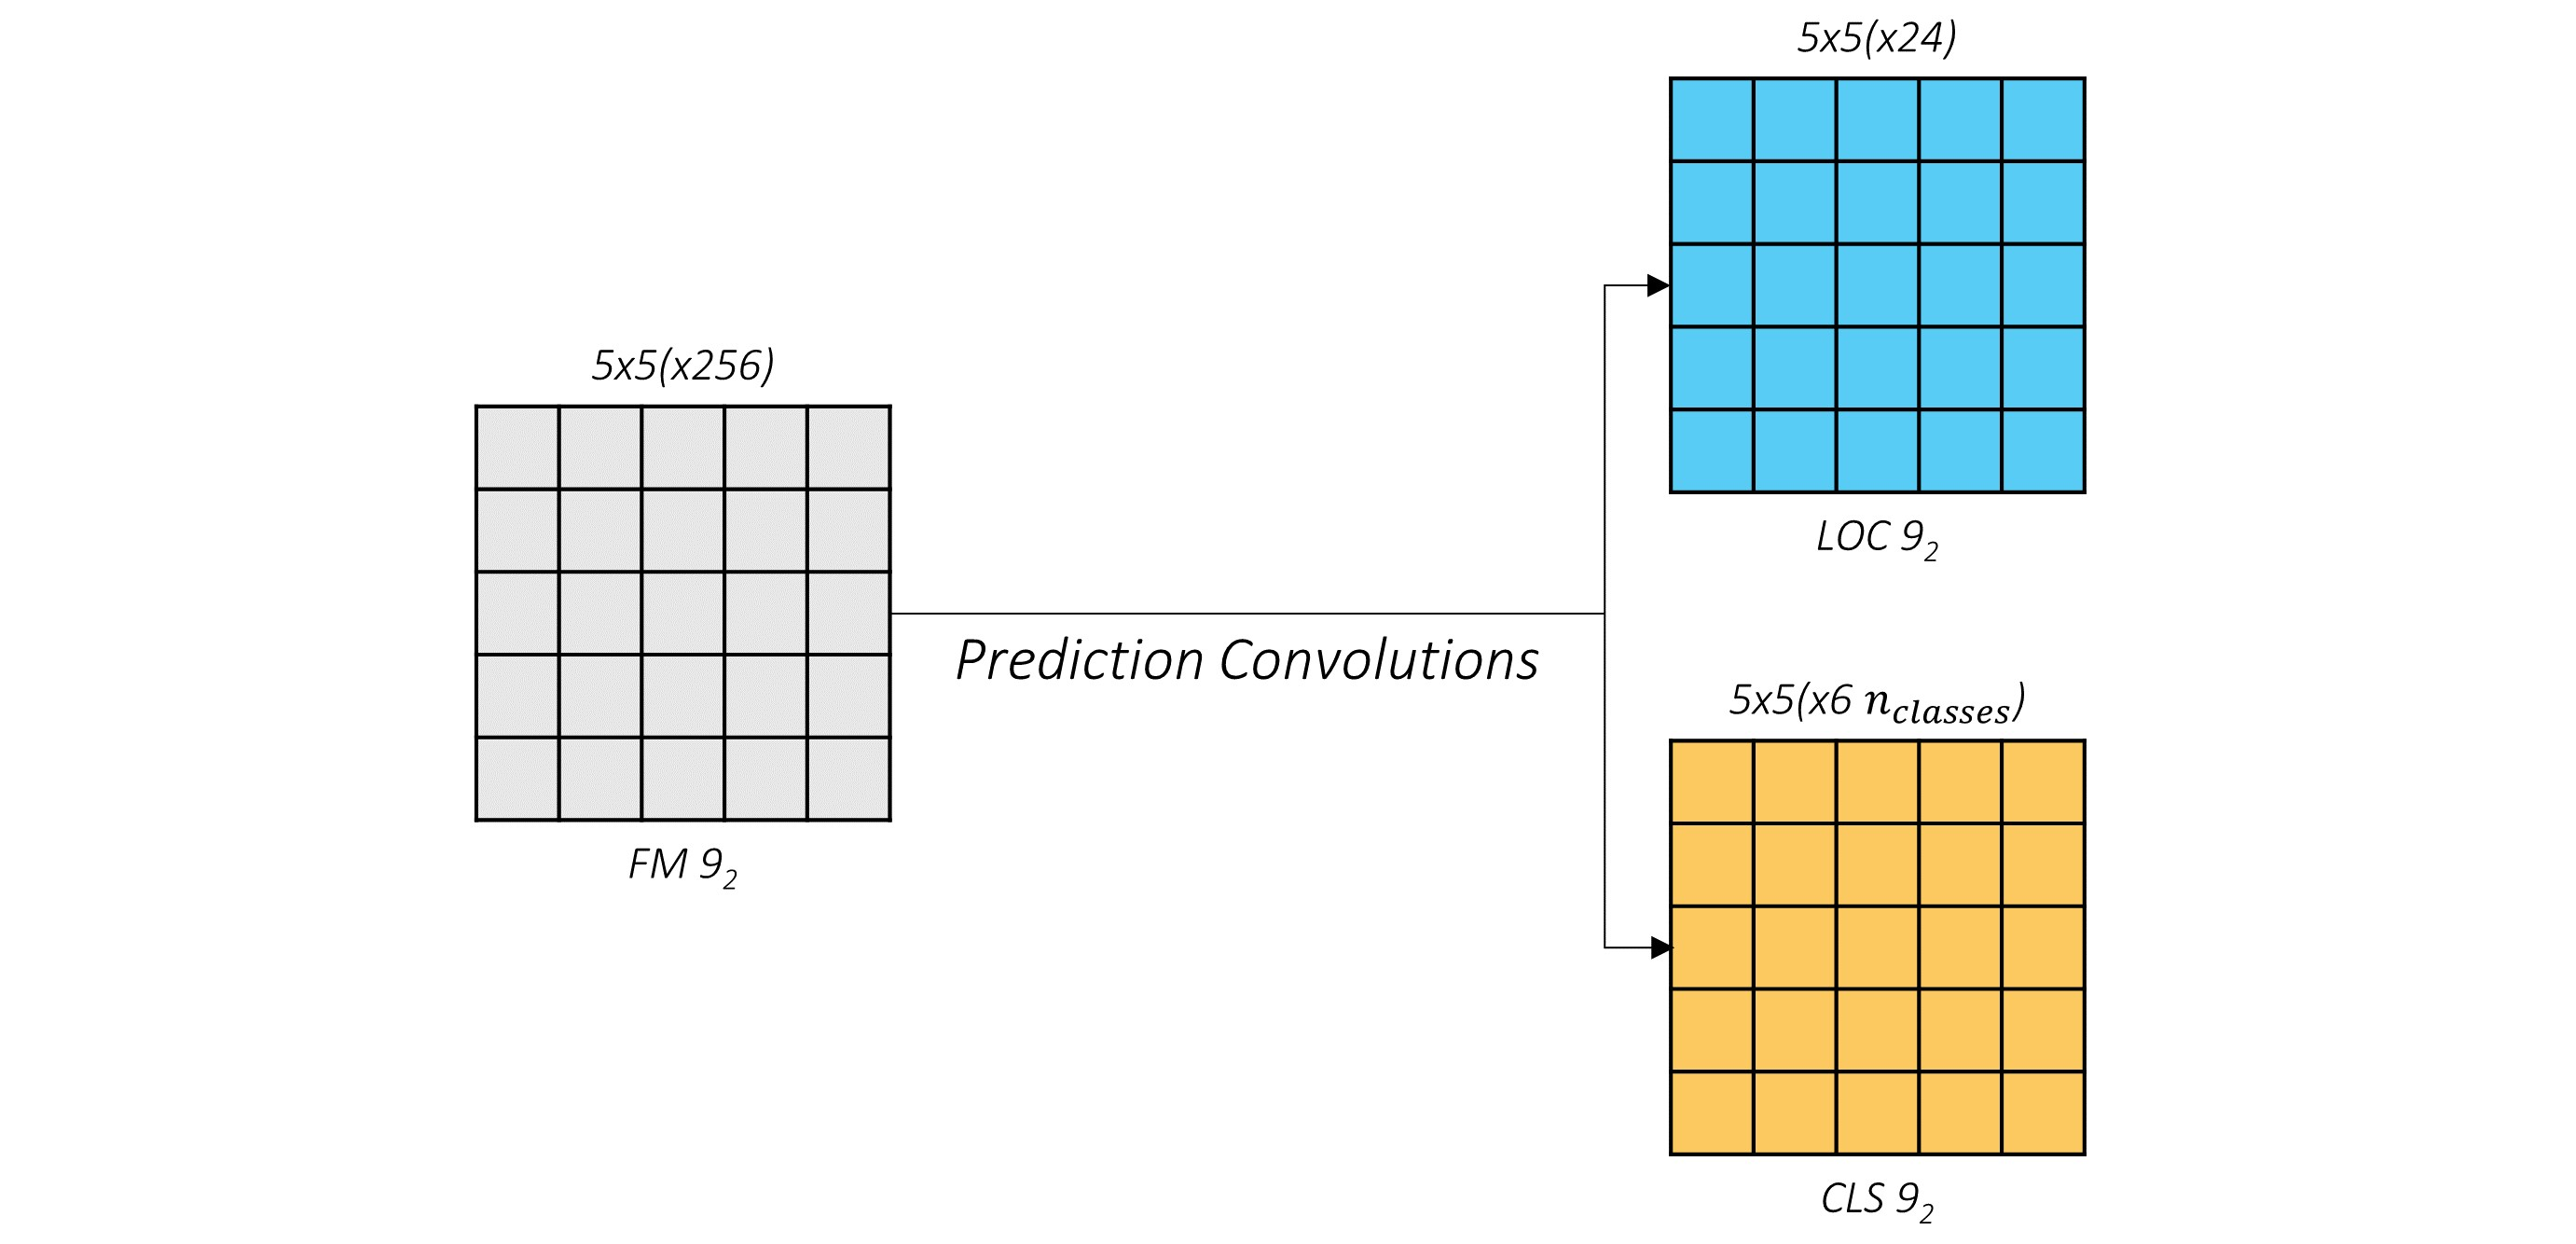

Данный блок получает фичи с Backbone и AuxiliaryConvolutionLayers и для каждых априорных боксов в пиксилях предсказывает их координаты центров, высоту с шириной, и вероятности принадленжости объекта каждому из классов. 

In [5]:
class PredictionConvolutions(nn.Module):
  def __init__(self, n_classes= 2):
    super().__init__()
    num_boxes = {'conv4_3': 4,
               'conv7': 6,
               'conv8_2': 6,
               'conv9_2': 6,
               'conv10_2': 4,
               'conv11_2': 4}
    self.n_classes= n_classes
    # box coordinates predicting
    self.coordinates_output4_3= nn.Conv2d(512, 4*num_boxes['conv4_3'], kernel_size= 3, stride= 1, padding= 1)
    self.coordinates_output7= nn.Conv2d(1024, 4*num_boxes['conv7'], kernel_size= 3, stride= 1, padding= 1)
    self.coordinates_output8= nn.Conv2d(512, 4*num_boxes['conv8_2'], kernel_size= 3, stride= 1, padding= 1)
    self.coordinates_output9= nn.Conv2d(256, 4*num_boxes['conv9_2'], kernel_size= 3, stride= 1, padding= 1)
    self.coordinates_output10= nn.Conv2d(256, 4*num_boxes['conv10_2'], kernel_size= 3, stride= 1, padding= 1)
    self.coordinates_output11= nn.Conv2d(256, 4*num_boxes['conv11_2'], kernel_size= 3, stride= 1, padding= 1)

    # class predicting for each box
    self.class_output4_3= nn.Conv2d(512, n_classes*num_boxes['conv4_3'], kernel_size= 3, stride= 1, padding= 1)
    self.class_output7= nn.Conv2d(1024, n_classes*num_boxes['conv7'], kernel_size= 3, stride= 1, padding= 1)
    self.class_output8= nn.Conv2d(512, n_classes*num_boxes['conv8_2'], kernel_size= 3, stride= 1, padding= 1)
    self.class_output9= nn.Conv2d(256, n_classes*num_boxes['conv9_2'], kernel_size= 3, stride= 1, padding= 1)
    self.class_output10= nn.Conv2d(256, n_classes*num_boxes['conv10_2'], kernel_size= 3, stride= 1, padding= 1)
    self.class_output11= nn.Conv2d(256, n_classes*num_boxes['conv11_2'], kernel_size= 3, stride= 1, padding= 1)

  def forward(self, output4_3, output7, output8, output9, output10, output11):
    batch_size= output4_3.shape[0]
    #[B, 4*nb, x, y] -> [B, x, y, 4*nb] -> [B, x*y*nb, 4]
    cr_output4_3= self.coordinates_output4_3(output4_3).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)   
    cr_output7= self.coordinates_output7(output7).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)
    cr_output8= self.coordinates_output8(output8).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)
    cr_output9= self.coordinates_output9(output9).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)
    cr_output10= self.coordinates_output10(output10).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)
    cr_output11= self.coordinates_output11(output11).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)

    #[B, num_cl*nb, x, y] -> [B, x, y, num_cl*nb] -> [B, x*y*nb, num_cl]
    cl_output4_3= self.class_output4_3(output4_3).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.n_classes) 
    cl_output7= self.class_output7(output7).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.n_classes) 
    cl_output8= self.class_output8(output8).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.n_classes) 
    cl_output9= self.class_output9(output9).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.n_classes) 
    cl_output10= self.class_output10(output10).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.n_classes) 
    cl_output11= self.class_output11(output11).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.n_classes)

    # [B, total bx count, 4]
    local= torch.cat((cr_output4_3, cr_output7, cr_output8, cr_output9, cr_output10, cr_output11), dim= 1) 
    # [B, total bx count, num_classes]
    classes_scores= torch.cat((cl_output4_3, cl_output7, cl_output8, cl_output9, cl_output10, cl_output11), dim= 1) 

    return local, classes_scores

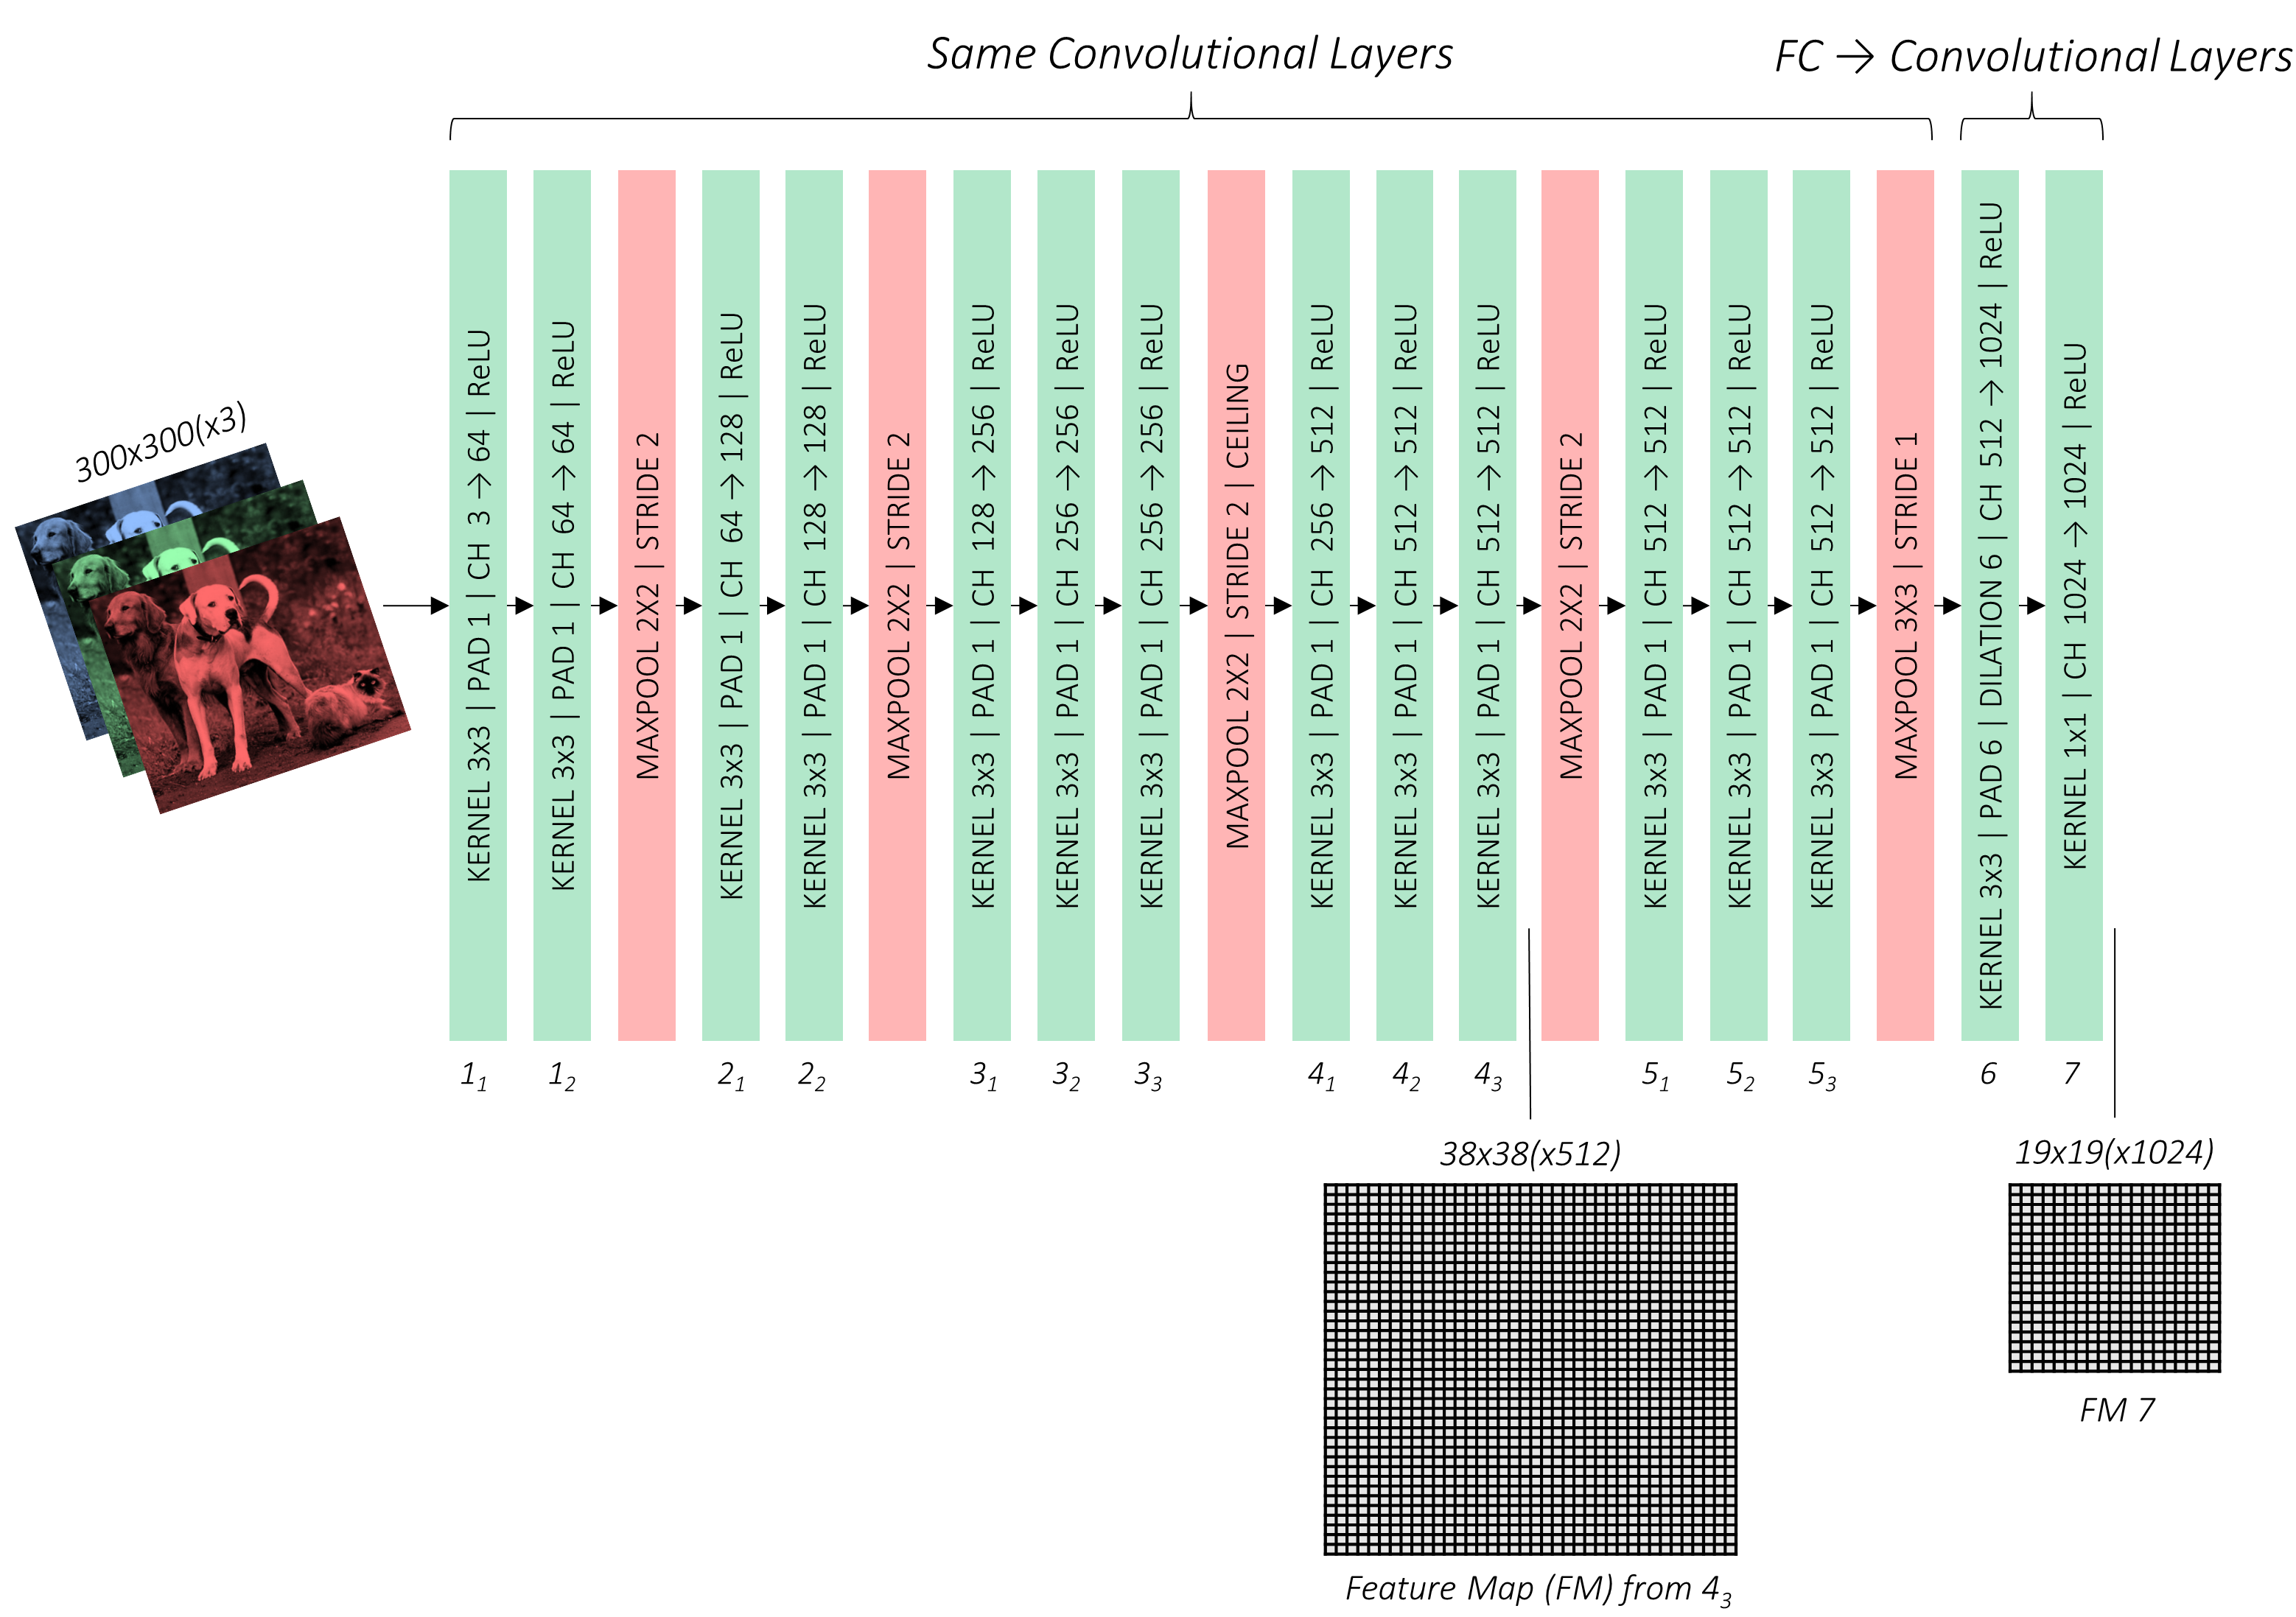

Данный блок-фичер экстрактор, представляет из себя VGG16 предообученную на ImageNet. Также в конце добавлено 2 сверточного слоя, которые обучаются, для нахождения более глубоких паттернов.

In [6]:
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models.feature_extraction import create_feature_extractor

In [7]:
class Backbone(nn.Module):
  def __init__(self):
    super().__init__()
    nodes = {'features.29':'features.29', 'features.22':'features.22'}
    self.vgg_based = create_feature_extractor(vgg16(weights= VGG16_Weights.IMAGENET1K_V1), return_nodes=nodes).eval()
    for param in self.vgg_based.parameters():
      param.requires_grad = False
    
    self.BatchNorm= nn.Sequential(
        nn.AdaptiveAvgPool2d((38, 38)),
        nn.BatchNorm2d(512),
    )
        
    
    self.conv6_7= nn.Sequential(
        nn.Conv2d(512, 1024, kernel_size= 3, stride=1, dilation= 6, padding= 6),
        nn.ReLU(),

        nn.Conv2d(1024, 1024, kernel_size= 1, stride= 1),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((19, 19))
    )

  def forward(self, x):
    output= self.vgg_based(x)
    output4_3= self.BatchNorm(output['features.22'])
    output7= self.conv6_7(output['features.29'])
    return output4_3, output7

In [8]:
class SSD(nn.Module):
  def __init__(self, n_classes= 2):
    super().__init__()
    self.n_classes= n_classes

    self.backbone = Backbone() # image size must be more than (300, 300)
    self.auxiliary_conv_layers= AuxiliaryConvolutionLayers(in_channels= 1024)
    self.box_class_predict= PredictionConvolutions(n_classes= n_classes)
    self.priors_cxcy = self.create_prior_boxes()
  
  def forward(self, image):
    output4_3, output7= self.backbone(image) # output4_3 ->[B, 512, 38, 38]; output7 -> [B, 1024, 19, 19]
    output8, output9, output10, output11= self.auxiliary_conv_layers(output7)
    local, classes_scores= self.box_class_predict(output4_3, output7, output8, output9, output10, output11)

    return local, classes_scores # [B, num_boxes, 4], [B, num_boxes, num_classes]

  
  def create_prior_boxes(self):
        fmap_dims = {'conv4_3': 38,
                     'conv7': 19,
                     'conv8': 10,
                     'conv9': 5,
                     'conv10': 3,
                     'conv11': 1}

        obj_scales = {'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8': 0.375,
                      'conv9': 0.55,
                      'conv10': 0.725,
                      'conv11': 0.9}

        # Слова обычно преобладают протяженных боксами, по-этому сделаем сделаем следующеее соотношение сторон
        aspect_ratios = {'conv4_3': [1., .25, .125],
                         'conv7': [1., .25, .125, .1, .08],
                         'conv8': [1.,  .5, .25, .125, .08],
                         'conv9': [1., .5, .25, .125, .08],
                         'conv10': [1., .25, .125],
                         'conv11': [1.,  .25, .125]}

        fmaps = list(fmap_dims.keys())

        prior_boxes = []

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])

                        # For an aspect ratio of 1, use an additional prior whose scale is the geometric mean of the
                        # scale of the current feature map and the scale of the next feature map
                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            # For the last feature map, there is no "next" feature map
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).to(device)  # (8732, 4)
        prior_boxes.clamp_(0, 1)  # (8732, 4)

        return prior_boxes

  def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        """
        Decipher the 8732 locations and class scores (output of ths SSD300) to detect objects.
        For each class, perform Non-Maximum Suppression (NMS) on boxes that are above a minimum threshold.
        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param min_score: minimum threshold for a box to be considered a match for a certain class
        :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via NMS
        :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
        :return: detections (boxes, labels, and scores), lists of length batch_size
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        predicted_scores = F.softmax(predicted_scores, dim=2)  # (N, 8732, n_classes)

        # Lists to store final predicted boxes, labels, and scores for all images
        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            # Decode object coordinates from the form we regressed predicted boxes to
            decoded_locs = cxcy_to_xy(
                gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))  # (8732, 4), these are fractional pt. coordinates

            # Lists to store boxes and scores for this image
            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1)  # (8732)

            # Check for each class
            for c in range(1, self.n_classes):
                # Keep only predicted boxes and scores where scores for this class are above the minimum score
                class_scores = predicted_scores[i][:, c]  # (8732)
                score_above_min_score = class_scores > min_score  # torch.uint8 (byte) tensor, for indexing
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                class_scores = class_scores[score_above_min_score]  # (n_qualified), n_min_score <= 8732
                class_decoded_locs = decoded_locs[score_above_min_score]  # (n_qualified, 4)

                # Sort predicted boxes and scores by scores
                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
                class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

                # Find the overlap between predicted boxes
                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  # (n_qualified, n_min_score)

                # Non-Maximum Suppression (NMS)

                # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
                # 1 implies suppress, 0 implies don't suppress
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)

                # Consider each box in order of decreasing scores
                for box in range(class_decoded_locs.size(0)):
                    # If this box is already marked for suppression
                    if suppress[box] == 1:
                        continue

                    # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
                    # Find such boxes and update suppress indices
                    suppress = torch.max(suppress, overlap[box] > max_overlap)
                    # The max operation retains previously suppressed boxes, like an 'OR' operation

                    # Don't suppress this box, even though it has an overlap of 1 with itself
                    suppress[box] = 0

                # Store only unsuppressed boxes for this class
                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
                image_scores.append(class_scores[1 - suppress])

            # If no object in any class is found, store a placeholder for 'background'
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))

            # Concatenate into single tensors
            image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
            image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
            image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
            n_objects = image_scores.size(0)

            # Keep only the top k objects
            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  # (top_k)
                image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
                image_labels = image_labels[sort_ind][:top_k]  # (top_k)

            # Append to lists that store predicted boxes and scores for all images
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size

In [9]:
def find_intersection(set_1, set_2):
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)

def find_jaccard_overlap(set_1, set_2):
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

def gcxgcy_to_cxcy(gcxgcy, priors_cxcy):
    return torch.cat([gcxgcy[:, :2] * priors_cxcy[:, 2:] / 10 + priors_cxcy[:, :2],  # c_x, c_y
                      torch.exp(gcxgcy[:, 2:] / 5) * priors_cxcy[:, 2:]], 1)  # w, h

def cxcy_to_gcxgcy(cxcy, priors_cxcy):
    return torch.cat([(cxcy[:, :2] - priors_cxcy[:, :2]) / (priors_cxcy[:, 2:] / 10),  # g_c_x, g_c_y
                      torch.log(cxcy[:, 2:] / priors_cxcy[:, 2:]) * 5], 1)  # g_w, g_h

def cxcy_to_xy(cxcy):
    return torch.cat([cxcy[:, :2] - (cxcy[:, 2:] / 2),  # x_min, y_min
                      cxcy[:, :2] + (cxcy[:, 2:] / 2)], 1)  # x_max, y_max

def xy_to_cxcy(xy):
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1)  # w, h

In [10]:
class MultiBoxLoss(nn.Module):
    """
    The MultiBox loss, a loss function for object detection.
    This is a combination of:
    (1) a localization loss for the predicted locations of the boxes, and
    (2) a confidence loss for the predicted class scores.
    """

    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        """
        Forward propagation.
        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param boxes: true  object bounding boxes in boundary coordinates, a list of N tensors
        :param labels: true object labels, a list of N tensors
        :return: multibox loss, a scalar
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)  # (N, 8732, 4)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)  # (N, 8732)

        # For each image
        for i in range(batch_size):
            n_objects = boxes[i].size(0)
            
            overlap = find_jaccard_overlap(boxes[i],
                                           self.priors_xy)  # (n_objects, 8732)

            # For each prior, find the object that has the maximum overlap
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  # (8732)
            _, prior_for_each_object = overlap.max(dim=1)  # (N_o)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)

            overlap_for_each_prior[prior_for_each_object] = 1.

            label_for_each_prior = labels[i][object_for_each_prior]  # (8732)
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0  # (8732)

            # Store
            true_classes[i] = label_for_each_prior

            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  # (8732, 4)

        positive_priors = true_classes != 0  # (N, 8732)

        # LOCALIZATION LOSS

        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  # (), scalar

        n_positives = positive_priors.sum(dim=1)  # (N)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)

        # First, find the loss for all priors
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  # (N * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)  # (N, 8732)

        # We already know which priors are positive
        conf_loss_pos = conf_loss_all[positive_priors]  # (sum(n_positives))

        # Next, find which priors are hard-negative
        # To do this, sort ONLY negative priors in each image in order of decreasing loss and take top n_hard_negatives
        conf_loss_neg = conf_loss_all.clone()  # (N, 8732)
        conf_loss_neg[positive_priors] = 0.  # (N, 8732), positive priors are ignored (never in top n_hard_negatives)
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  # (N, 8732), sorted by decreasing hardness
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)  # (N, 8732)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, 8732)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

        # As in the paper, averaged over positive priors only, although computed over both positive and hard-negative priors
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()  # (), scalar

        # TOTAL LOSS
        return conf_loss + self.alpha * loc_loss

#### SSD обучение

In [82]:
def train(model, criterion, optimizer, train_data_loader, test_data_loader, scheduler, savepoint= 5, checkpoint= 2, start_epoch=1):
  loss_train_history, loss_test_history= [], []

  for epoch in tqdm(range(start_epoch, max_epoch+start_epoch)):
    print(epoch)
    dtime= datetime.datetime.today()
    batch_train_counter, batch_test_counter= 0, 0
    loss_train_counter, loss_test_counter= 0, 0

    model.train()
    for images, _, _, coordinates in tqdm(train_data_loader):
      images= images.to(device)
      coordinates= coordinates[:, None, :].to(device)
      labels= torch.ones((batch_size, 1)).to(device)

      optimizer.zero_grad()
      predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)
      loss = criterion(predicted_locs, predicted_scores, coordinates, labels)  # scalar
      loss.backward()
      optimizer.step()

      batch_train_counter+= 1
      loss_train_counter+= loss.to('cpu')
    
    loss_train_history.append(loss_train_counter/batch_train_counter)
    scheduler.step()

    ##############################################################
    model.eval()
    with torch.no_grad():
      if epoch % checkpoint==0:
        for image_batch, _, _, coordinates in tqdm(test_data_loader):
          image_batch= image_batch.to(device)
          coordinates= coordinates[:, None, :].to(device)
          labels= torch.ones((batch_size, 1)).to(device)

          predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)
          # det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
          #                                                                              min_score=0.4, max_overlap=0.5,
          #                                                                              top_k=200)
          
          loss = criterion(predicted_locs, predicted_scores, coordinates, labels)  # scalar

          batch_test_counter+= 1
          loss_test_counter+= loss.to('cpu')

        clear_output(wait=False)
        loss_test_history.append(loss_test_counter/batch_test_counter)

        fig, ax= plt.subplots(nrows= 1, ncols= 2, figsize= (16,10))
        ax[0].plot(np.arange(start_epoch, epoch+1, 1), loss_train_history)
        ax[1].plot(np.arange(start_epoch, epoch+1, checkpoint), loss_test_history)
        ax[0].set_title('train')
        ax[1].set_title('test')
        plt.show()
  
      
      if epoch % savepoint == 0: 
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/data/SSD/TRM{}_{}_{}.pt'.format(epoch,dtime.hour, dtime.minute))
        torch.save(model.state_dict(), '/content/TRM{}_{}_{}.pt'.format(epoch,dtime.hour, dtime.minute))

Запустим обучение при параметрах: lr= 1E-4, 
batch_size= 32,
max_epoch= 10.

Графики train и text продолжают дроматично убывать, 10 эпох для обучения было не достаточно. Продолжим обучение.

In [13]:
class MyData(Dataset):
  def __init__(self, text_data, image_size= (128, 32), word_length= 10, letter_size=(14,18), L_mode= True, random_image= False):
    self.text_data= text_data
    self.Fonts= glob.glob('/content/gdrive/MyDrive/data/Fonts/*.ttf')
    #self.DataImages= list(Path('/content/gdrive/MyDrive/data/DIV2K_train_LR_bicubic_X4/DIV2K_train_LR_bicubic/X4').rglob('*.png'))
    self.DataImages= list(Path('/content/DIV2K_train_HR/DIV2K_train_HR/').rglob('*.png'))
    self.image_size= image_size
    self.word_length= word_length
    self.random_image= random_image
    self.letter_size= letter_size
    self.L_mode= L_mode
    
    self.crop= tt.RandomCrop(image_size[::-1])

    self.second_transform= tt.Compose([
        tt.RandomRotation(degrees= 5, fill= 255),
        tt.ToTensor(),
        tt.ConvertImageDtype(torch.float), #-> [0,1]
    ])

  def text_to_target(self, text_data):
    text_data= text_data+'^'*(self.word_length-len(text_data))
    return torch.tensor([alphabet_dct[letter] for letter in text_data])
  
  def target_to_text(self, target):
    return ([alphabet[letter] for letter in target])

  def create_image(self, text_data):
    size= np.random.randint(*self.letter_size)
    if self.random_image:
      image= self.crop(Image.open(np.random.choice(self.DataImages)))
      if self.L_mode: image= image.convert('L')
    else:
      image = Image.new(mode="L", size=self.image_size, color="white")
    font = ImageFont.truetype(np.random.choice(self.Fonts), size= size)
    text_data_size = np.array(font.getsize(text_data))
    x_start, y_start= np.random.uniform(low=self.image_size[0]*0.05, high= self.image_size[0]/1.2-text_data_size[0]), np.random.uniform(low=self.image_size[1]*0.05, high= self.image_size[1]/1.2-text_data_size[1])
    x_end, y_end= x_start+text_data_size[0], y_start+text_data_size[1]
    #delta_x, delta_y= sqrt(sum(text_data_size**2))*(1-np.cos(5/57.3))/2, sqrt(sum(text_data_size**2))*np.sin(5/57.3)/2
    #print(delta_x, delta_y, x_start, y_start, text_data_size)
    delta_x, delta_y= text_data_size[0]*0.05, text_data_size[1]*0.3
    #coordinates= torch.tensor([x_start-1.3*delta_x-3, y_start-1.3*delta_y-1, x_end+1.3*delta_x+3, y_end+1.3*delta_y+1]) # увеличиваем размеры, чтобы все слово попадало на картинку при повороде, желательно нужно прибавлять и убавлят по5
    coordinates= torch.tensor([(x_start-delta_x-3)/self.image_size[0], (y_start-delta_y-2)/self.image_size[1], (x_end+delta_x+3)/self.image_size[0], (y_end+delta_y+2)/self.image_size[1]])

    draw = ImageDraw.Draw(image)
    draw.text((x_start, y_start), text_data, font=font, fill= 'black')

    image= self.second_transform(image)

    return image, coordinates

  def __len__(self):
    return len(self.text_data)
  
  def __getitem__(self, index):
    sentence= self.text_data[index] # семплируем слово
    target= self.text_to_target(sentence) # имбидим его
    image, coordinates= self.create_image(sentence)

    return image, target, len(sentence), coordinates

In [ ]:
text_data=  pd.read_csv("/content/lenta-ru-news.csv")['text'][:10**3]
correct_sentence= set()
for idx, sentence in tqdm(enumerate(text_data)):  # Убираем англоязычные слова. Также в присутствуют пустые предложения, которые обрабатываются try-except
  try:
    for word in sentence.strip().split():
      if set(word) & set(alphabet) == set(word)  and 4<=len(word)<14 and word not in correct_sentence:
        correct_sentence.add(word)
  except:
    pass

text_data= np.array([*correct_sentence])
print(len(text_data), text_data[:5])

In [57]:
random_state= 42
x_train, x_test= train_test_split(text_data, test_size= 0.2, shuffle= True, random_state= random_state)

In [15]:
batch_size= 32
random_state= 42
train_data_loader= DataLoader(MyData(x_train, random_image= True, word_length=14, image_size= (300, 300), letter_size=(14, 26), L_mode= False), batch_size= batch_size, shuffle= True, num_workers= 2, drop_last= True, pin_memory= True)
test_data_loader= DataLoader(MyData(x_test, random_image= True, word_length=14, image_size= (300, 300), letter_size=(14, 26), L_mode= False), batch_size= batch_size, shuffle= True,num_workers= 2, drop_last= True, pin_memory= True)

In [16]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
lr= 1E-3
max_epoch= 25
savepoint= 5
checkpoint= 2
num_workers= 2
dtime= datetime.datetime.today()

In [17]:
model= SSD(n_classes= 2).to(device)
optimizer= torch.optim.Adam(model.parameters(), lr= lr)
criterion= MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)
scheduler= torch.optim.lr_scheduler.MultiStepLR(optimizer, [25], gamma= 0.1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Веса SSD20_21_47

In [ ]:
train(model, criterion, optimizer, train_data_loader, test_data_loader, scheduler, start_epoch= 1)

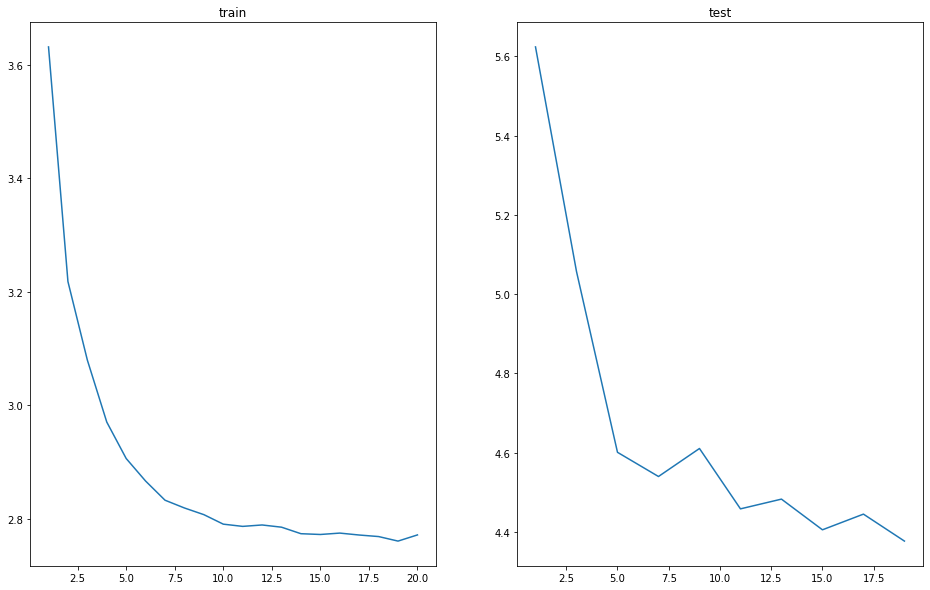

##### Результаты

In [29]:
model.load_state_dict(torch.load('/content/SSD20_21_47.pt'))
model.eval()
clear_output()

1


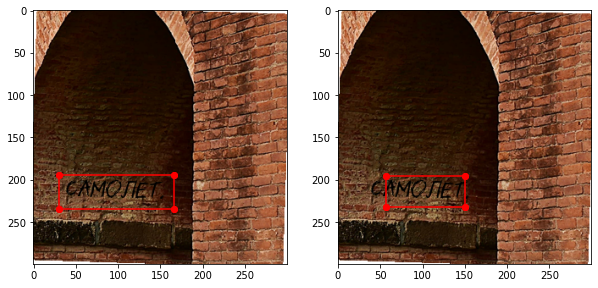

1


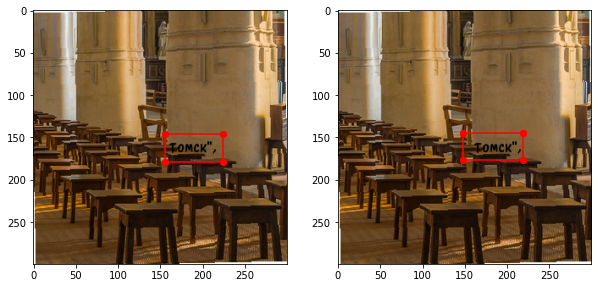

1


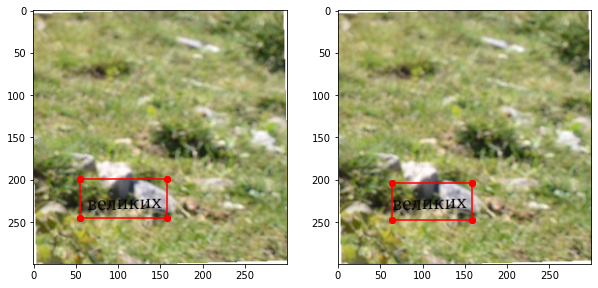

In [72]:
check= MyData(x_test, random_image= True, word_length=14, image_size= (300, 300), letter_size=(14, 26), L_mode= False)
with torch.no_grad():
  for i in range(3):
    image, target, length, coordinates= check.__getitem__(np.random.randint(low=0, high=100))
    fig, ax= plt.subplots(nrows= 1, ncols= 2,figsize= (10, 20))
    ax[0].imshow(image.permute(1,2,0).to('cpu'))
    coordinates= coordinates*300
    x1, x2, x3= [coordinates[0], coordinates[2]], [coordinates[0], coordinates[0]], [coordinates[2], coordinates[2]]
    y1, y2, y3= [coordinates[1], coordinates[3]], [coordinates[1], coordinates[1]], [coordinates[3], coordinates[3]]
    ax[0].plot(x1, y2,marker = 'o', color='red')
    ax[0].plot(x1, y3, marker= 'o', color='red')
    ax[0].plot(x2, y1, marker= 'o', color='red')
    ax[0].plot(x3, y1, marker= 'o', color='red')

    image= image.to(device)
    predicted_locs, predicted_scores = model(image[None,:,:,:])
    det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
                                                                                min_score=0.01, max_overlap=0.4,
                                                                                top_k=100)
    print(len(det_boxes_batch))
    ax[1].imshow(image.permute(1,2,0).to('cpu'))
    coordinates= det_boxes_batch[0][0].to('cpu')*300
    x1, x2, x3= [coordinates[0], coordinates[2]], [coordinates[0], coordinates[0]], [coordinates[2], coordinates[2]]
    y1, y2, y3= [coordinates[1], coordinates[3]], [coordinates[1], coordinates[1]], [coordinates[3], coordinates[3]]
    ax[1].plot(x1, y2,marker = 'o', color='red')
    ax[1].plot(x1, y3, marker= 'o', color='red')
    ax[1].plot(x2, y1, marker= 'o', color='red')
    ax[1].plot(x3, y1, marker= 'o', color='red')
    plt.show()

#### Улучшение и дообучение SSD

Модель обучилась видеть слова, но при этом слова малого маштаба она детектирует не очень точно, при это некоторая часть боксов смещена вправом или влево, и все слово целеком не влезает, эта проблема возникает за счет поворотов картинок (при этом, я уже делал поправки на это). Чтобы улучшить результат я уменьшу соотношение сторон, при этом чуть-чуть расширю боксы.

##### Корректировка классов

Увеличил поправки к размеру боксов.

In [73]:
class MyData(Dataset):
  def __init__(self, text_data, image_size= (128, 32), word_length= 10, letter_size=(14,18), L_mode= True, random_image= False):
    self.text_data= text_data
    self.Fonts= glob.glob('/content/gdrive/MyDrive/data/Fonts/*.ttf')
    #self.DataImages= list(Path('/content/gdrive/MyDrive/data/DIV2K_train_LR_bicubic_X4/DIV2K_train_LR_bicubic/X4').rglob('*.png'))
    self.DataImages= list(Path('/content/DIV2K_train_HR/DIV2K_train_HR/').rglob('*.png'))
    self.image_size= image_size
    self.word_length= word_length
    self.random_image= random_image
    self.letter_size= letter_size
    self.L_mode= L_mode
    
    self.crop= tt.RandomCrop(image_size[::-1])

    self.second_transform= tt.Compose([
        tt.RandomRotation(degrees= 5, fill= 255),
        tt.ToTensor(),
        tt.ConvertImageDtype(torch.float), #-> [0,1]
    ])

  def text_to_target(self, text_data):
    text_data= text_data+'^'*(self.word_length-len(text_data))
    return torch.tensor([alphabet_dct[letter] for letter in text_data])
  
  def target_to_text(self, target):
    return ([alphabet[letter] for letter in target])

  def create_image(self, text_data):
    size= np.random.randint(*self.letter_size)
    if self.random_image:
      image= self.crop(Image.open(np.random.choice(self.DataImages)))
      if self.L_mode: image= image.convert('L')
    else:
      image = Image.new(mode="L", size=self.image_size, color="white")
    font = ImageFont.truetype(np.random.choice(self.Fonts), size= size)
    text_data_size = np.array(font.getsize(text_data))
    x_start, y_start= np.random.uniform(low=self.image_size[0]*0.05, high= self.image_size[0]/1.2-text_data_size[0]), np.random.uniform(low=self.image_size[1]*0.05, high= self.image_size[1]/1.2-text_data_size[1])
    x_end, y_end= x_start+text_data_size[0], y_start+text_data_size[1]
    #delta_x, delta_y= sqrt(sum(text_data_size**2))*(1-np.cos(5/57.3))/2, sqrt(sum(text_data_size**2))*np.sin(5/57.3)/2
    #print(delta_x, delta_y, x_start, y_start, text_data_size)
    delta_x, delta_y= text_data_size[0]*0.08, text_data_size[1]*0.4
    #coordinates= torch.tensor([x_start-1.3*delta_x-3, y_start-1.3*delta_y-1, x_end+1.3*delta_x+3, y_end+1.3*delta_y+1]) # увеличиваем размеры, чтобы все слово попадало на картинку при повороде, желательно нужно прибавлять и убавлят по5
    coordinates= torch.tensor([(x_start-delta_x-4)/self.image_size[0], (y_start-delta_y-3)/self.image_size[1], (x_end+delta_x+4)/self.image_size[0], (y_end+delta_y+3)/self.image_size[1]])

    draw = ImageDraw.Draw(image)
    draw.text((x_start, y_start), text_data, font=font, fill= 'black')

    image= self.second_transform(image)

    return image, coordinates

  def __len__(self):
    return len(self.text_data)
  
  def __getitem__(self, index):
    sentence= self.text_data[index] # семплируем слово
    target= self.text_to_target(sentence) # имбидим его
    image, coordinates= self.create_image(sentence)

    return image, target, len(sentence), coordinates

Уменьшил соотношение стороны для боксов

In [92]:
class SSD(nn.Module):
  def __init__(self, n_classes= 2):
    super().__init__()
    self.n_classes= n_classes

    self.backbone = Backbone() # image size must be more than (300, 300)
    self.auxiliary_conv_layers= AuxiliaryConvolutionLayers(in_channels= 1024)
    self.box_class_predict= PredictionConvolutions(n_classes= n_classes)
    self.priors_cxcy = self.create_prior_boxes()
  
  def forward(self, image):
    output4_3, output7= self.backbone(image) # output4_3 ->[B, 512, 38, 38]; output7 -> [B, 1024, 19, 19]
    output8, output9, output10, output11= self.auxiliary_conv_layers(output7)
    local, classes_scores= self.box_class_predict(output4_3, output7, output8, output9, output10, output11)

    return local, classes_scores # [B, num_boxes, 4], [B, num_boxes, num_classes]

  
  def create_prior_boxes(self):
        fmap_dims = {'conv4_3': 38,
                     'conv7': 19,
                     'conv8': 10,
                     'conv9': 5,
                     'conv10': 3,
                     'conv11': 1}

        obj_scales = {'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8': 0.375,
                      'conv9': 0.55,
                      'conv10': 0.725,
                      'conv11': 0.9}

        # Слова обычно преобладают протяженных боксами, по-этому сделаем сделаем следующеее соотношение сторон
        aspect_ratios = {'conv4_3': [1., .2, .08],
                         'conv7': [1., .2, .125, .1, .06],
                         'conv8': [1.,  .3, .2, .125, .06],
                         'conv9': [1., .3, .2, .125, .06],
                         'conv10': [1., .2, .1],
                         'conv11': [1.,  .2, .1]}

        fmaps = list(fmap_dims.keys())

        prior_boxes = []

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])

                        # For an aspect ratio of 1, use an additional prior whose scale is the geometric mean of the
                        # scale of the current feature map and the scale of the next feature map
                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            # For the last feature map, there is no "next" feature map
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).to(device)  # (8732, 4)
        prior_boxes.clamp_(0, 1)  # (8732, 4)

        return prior_boxes

  def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        """
        Decipher the 8732 locations and class scores (output of ths SSD300) to detect objects.
        For each class, perform Non-Maximum Suppression (NMS) on boxes that are above a minimum threshold.
        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param min_score: minimum threshold for a box to be considered a match for a certain class
        :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via NMS
        :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
        :return: detections (boxes, labels, and scores), lists of length batch_size
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        predicted_scores = F.softmax(predicted_scores, dim=2)  # (N, 8732, n_classes)

        # Lists to store final predicted boxes, labels, and scores for all images
        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            # Decode object coordinates from the form we regressed predicted boxes to
            decoded_locs = cxcy_to_xy(
                gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))  # (8732, 4), these are fractional pt. coordinates

            # Lists to store boxes and scores for this image
            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1)  # (8732)

            # Check for each class
            for c in range(1, self.n_classes):
                # Keep only predicted boxes and scores where scores for this class are above the minimum score
                class_scores = predicted_scores[i][:, c]  # (8732)
                score_above_min_score = class_scores > min_score  # torch.uint8 (byte) tensor, for indexing
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                class_scores = class_scores[score_above_min_score]  # (n_qualified), n_min_score <= 8732
                class_decoded_locs = decoded_locs[score_above_min_score]  # (n_qualified, 4)

                # Sort predicted boxes and scores by scores
                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
                class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

                # Find the overlap between predicted boxes
                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  # (n_qualified, n_min_score)

                # Non-Maximum Suppression (NMS)

                # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
                # 1 implies suppress, 0 implies don't suppress
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)

                # Consider each box in order of decreasing scores
                for box in range(class_decoded_locs.size(0)):
                    # If this box is already marked for suppression
                    if suppress[box] == 1:
                        continue

                    # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
                    # Find such boxes and update suppress indices
                    suppress = torch.max(suppress, overlap[box] > max_overlap)
                    # The max operation retains previously suppressed boxes, like an 'OR' operation

                    # Don't suppress this box, even though it has an overlap of 1 with itself
                    suppress[box] = 0

                # Store only unsuppressed boxes for this class
                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
                image_scores.append(class_scores[1 - suppress])

            # If no object in any class is found, store a placeholder for 'background'
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))

            # Concatenate into single tensors
            image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
            image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
            image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
            n_objects = image_scores.size(0)

            # Keep only the top k objects
            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  # (top_k)
                image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
                image_labels = image_labels[sort_ind][:top_k]  # (top_k)

            # Append to lists that store predicted boxes and scores for all images
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size

##### Дообучение

In [75]:
model.load_state_dict(torch.load('/content/SSD20_21_47.pt'))
model.eval()
clear_output()

In [99]:
random_state= 42
x_train, x_test= train_test_split(text_data, test_size= 0.2, shuffle= True, random_state= random_state)

In [100]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
lr= 1E-3
max_epoch=6
savepoint= 6
checkpoint= 2
num_workers= 2
dtime= datetime.datetime.today()

In [101]:
batch_size= 32
random_state= 42
train_data_loader= DataLoader(MyData(x_train, random_image= True, word_length=14, image_size= (300, 300), letter_size=(14, 26), L_mode= False), batch_size= batch_size, shuffle= True, num_workers= 2, drop_last= True, pin_memory= True)
test_data_loader= DataLoader(MyData(x_test, random_image= True, word_length=14, image_size= (300, 300), letter_size=(14, 26), L_mode= False), batch_size= batch_size, shuffle= True,num_workers= 2, drop_last= True, pin_memory= True)

In [102]:
model= SSD(n_classes= 2).to(device)
model.load_state_dict(torch.load('/content/SSD20_21_47.pt'))
model.eval()
clear_output()
optimizer= torch.optim.Adam(model.parameters(), lr= lr)
criterion= MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)
scheduler= torch.optim.lr_scheduler.MultiStepLR(optimizer, [5], gamma= 0.1)

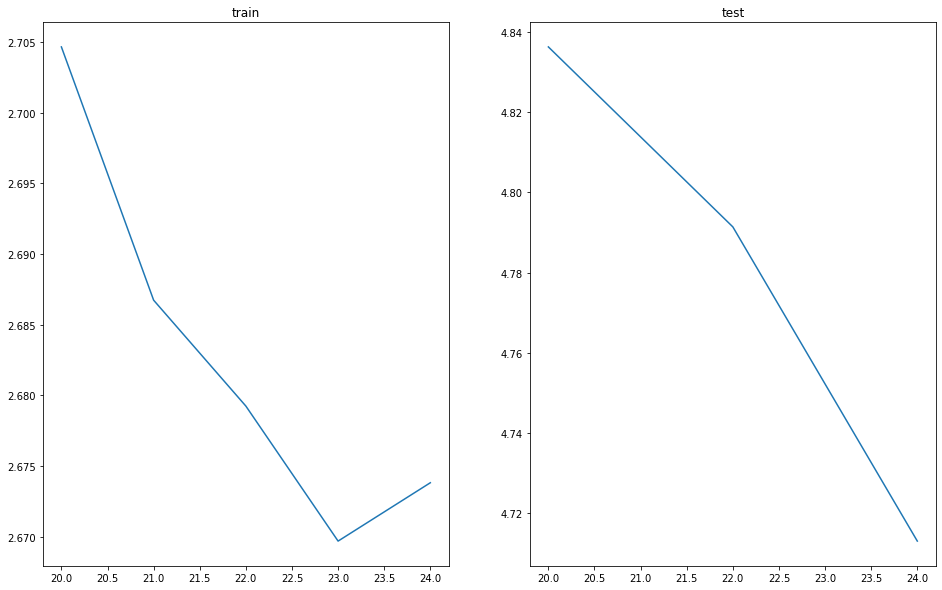

25


  0%|          | 0/979 [00:00<?, ?it/s]

In [103]:
train(model, criterion, optimizer, train_data_loader, test_data_loader, scheduler, start_epoch= 20)

Заметного изменения лосс функции больше нет, по-этому было принято остановить обучения модели на 30 эпохах.

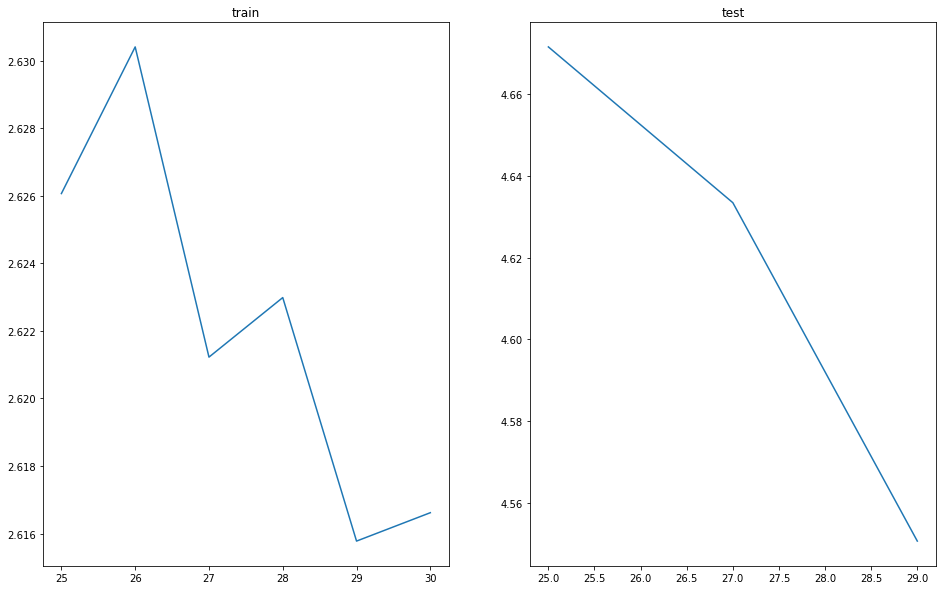

In [106]:
lr= 1E-4
max_epoch=5
max_epoch=6
savepoint= 5
train(model, criterion, optimizer, train_data_loader, test_data_loader, scheduler, start_epoch= 25)

In [104]:
torch.save(model.state_dict(), '/content/SSD{}_{}_{}.pt'.format(30,dtime.hour, dtime.minute))

1


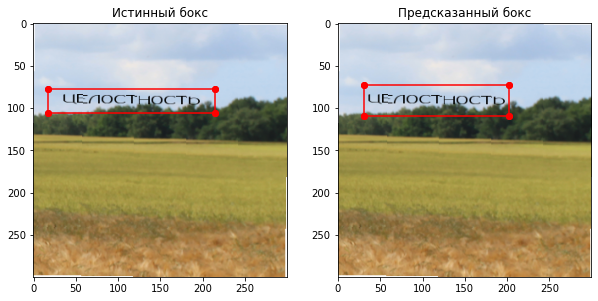

1


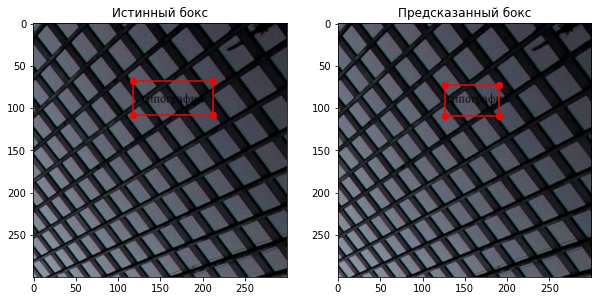

1


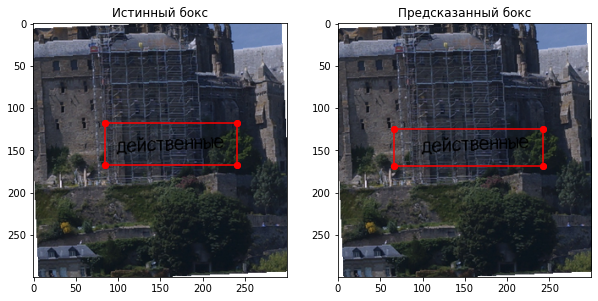

In [107]:
check= MyData(x_test, random_image= True, word_length=14, image_size= (300, 300), letter_size=(14, 26), L_mode= False)
with torch.no_grad():
  for i in range(3):
    image, target, length, coordinates= check.__getitem__(np.random.randint(low=0, high=100))
    fig, ax= plt.subplots(nrows= 1, ncols= 2,figsize= (10, 20))
    ax[0].imshow(image.permute(1,2,0).to('cpu'))
    coordinates= coordinates*300
    x1, x2, x3= [coordinates[0], coordinates[2]], [coordinates[0], coordinates[0]], [coordinates[2], coordinates[2]]
    y1, y2, y3= [coordinates[1], coordinates[3]], [coordinates[1], coordinates[1]], [coordinates[3], coordinates[3]]
    ax[0].plot(x1, y2,marker = 'o', color='red')
    ax[0].plot(x1, y3, marker= 'o', color='red')
    ax[0].plot(x2, y1, marker= 'o', color='red')
    ax[0].plot(x3, y1, marker= 'o', color='red')
    ax[0].set_title('Истинный бокс')

    image= image.to(device)
    predicted_locs, predicted_scores = model(image[None,:,:,:])
    det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
                                                                                min_score=0.01, max_overlap=0.4,
                                                                                top_k=100)
    print(len(det_boxes_batch))
    ax[1].imshow(image.permute(1,2,0).to('cpu'))
    coordinates= det_boxes_batch[0][0].to('cpu')*300
    x1, x2, x3= [coordinates[0], coordinates[2]], [coordinates[0], coordinates[0]], [coordinates[2], coordinates[2]]
    y1, y2, y3= [coordinates[1], coordinates[3]], [coordinates[1], coordinates[1]], [coordinates[3], coordinates[3]]
    ax[1].plot(x1, y2,marker = 'o', color='red')
    ax[1].plot(x1, y3, marker= 'o', color='red')
    ax[1].plot(x2, y1, marker= 'o', color='red')
    ax[1].plot(x3, y1, marker= 'o', color='red')
    ax[1].set_title('Предсказанный бокс')
    plt.show()

#### Используемая литература

* [An End-to-End Trainable Neural Network for Image-based Sequence
Recognition and Its Application to Scene Text Recognition](https://arxiv.org/pdf/1507.05717.pdf)

* [SSD: Single Shot MultiBox Detector](https://arxiv.org/pdf/1512.02325.pdf)

* [Gighub PyTorch-Tutorial-to-Object-Detection](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection)